In [1]:
### importing libraries

from datetime import datetime,timedelta
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

import json
import os
import gc

In [2]:
### seting the data directory

datset_rel_path = 'data/dataset/'

In [3]:
cwd = os.getcwd()
cwd

'/home/sidd/workspace/Student-Stress-Prediction'

In [4]:
label_df = pd.read_csv('./data/label_df.csv')
label_df.head()

,user_id,date_time,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u00,2013-03-25 11:54:00,2013,3,25,11,54,Mon,12,stress_ema,2,1
1,u00,2013-03-25 20:33:00,2013,3,25,20,33,Mon,12,stress_ema,2,1
2,u00,2013-03-26 18:12:00,2013,3,26,18,12,Tue,12,stress_ema,1,0
3,u00,2013-03-27 19:25:00,2013,3,27,19,25,Wed,12,stress_ema,1,0
4,u00,2013-03-28 11:43:00,2013,3,28,11,43,Thu,12,stress_ema,2,1


In [5]:
label_df['date_time'] = pd.to_datetime(label_df['date_time'])
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       2455 non-null   object        
 1   date_time     2455 non-null   datetime64[ns]
 2   year          2455 non-null   int64         
 3   month         2455 non-null   int64         
 4   day           2455 non-null   int64         
 5   hours         2455 non-null   int64         
 6   minute        2455 non-null   int64         
 7   weekday       2455 non-null   object        
 8   weeknumber    2455 non-null   int64         
 9   label_source  2455 non-null   object        
 10  rating        2455 non-null   int64         
 11  stress_label  2455 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 230.3+ KB


## Utility function

In [6]:
# # label_df['date_time'].nunique(),len(label_df)

# dup_sum =0

# for u in label_df['user_id'].unique():
#     t_df = label_df[label_df['user_id'] == u ]
#     uni_en = len(set(t_df['date_time']))
#     en = len(t_df)
#     if uni_en != en:
#         print(u,uni_en,en)
#         dup_sum += en-uni_en

# dup_sum



In [7]:
start_time =  1357032225
# end_time = 1371284625


def get_date_time(timestamp):
  return datetime.fromtimestamp(timestamp).strftime("%m/%d/%Y, %H:%M:%S")

get_date_time(start_time)#,get_date_time(end_time)

'01/01/2013, 01:23:45'

In [8]:
get_date_time(start_time) == get_date_time(start_time)

True

## App usage

In [9]:
app_usage_path = os.path.join(datset_rel_path,'app_usage')

app_usage_files = os.listdir(app_usage_path)
len(app_usage_files)

49

In [10]:
app_usage_files[0].split('_')[-1].split('.')[0]

'u53'

In [11]:
for app_usage_file in app_usage_files:
    usr_id = app_usage_file.split('_')[-1].split('.')[0]

    if usr_id not in set(label_df['user_id'].unique()):
        print(usr_id)

u13


In [12]:
# tmp_li = [get_date_time(start_time)]
# tmp_li.extend(list(label_df[label_df['user_id'] == usr_id].date_time))
# len(tmp_li)

In [13]:
AGGREGATION_DAYS = 2


app_usage_di = defaultdict(list)


for app_usage_file in tqdm(app_usage_files):
    usr_id = app_usage_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(app_usage_path,app_usage_file))

    tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])

    # time stamps
    # tmp_li = [get_date_time(start_time)]
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)
    
    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]

        app_usage_di['user_id'].append(usr_id)
        app_usage_di['date_time'].append(time_b)

        app_usage_di['app_usage_baseActivity_mClass'].append(len(set(slice_df['RUNNING_TASKS_baseActivity_mClass'])))
        app_usage_di['app_usage_baseActivity_mPackage'].append(len(set(slice_df['RUNNING_TASKS_baseActivity_mPackage'])))
        app_usage_di['app_usage_baseActivity_id_count'].append(len(set(slice_df['RUNNING_TASKS_id'])))

        app_usage_di['app_usage_baseActivity_numActivities'].append(slice_df['RUNNING_TASKS_numActivities'].sum())
        app_usage_di['app_usage_baseActivity_numRunning'].append(slice_df['RUNNING_TASKS_numRunning'].sum())

        app_usage_di['app_usage_topActivity_mClass'].append(len(set(slice_df['RUNNING_TASKS_topActivity_mClass'])))
        app_usage_di['app_usage_topActivity_mPackage'].append(len(set(slice_df['RUNNING_TASKS_topActivity_mPackage'])))



100%|██████████| 49/49 [00:17<00:00,  2.80it/s]


In [14]:
for k,val in app_usage_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
app_usage_baseActivity_mClass 2455
app_usage_baseActivity_mPackage 2455
app_usage_baseActivity_id_count 2455
app_usage_baseActivity_numActivities 2455
app_usage_baseActivity_numRunning 2455
app_usage_topActivity_mClass 2455
app_usage_topActivity_mPackage 2455


In [15]:
app_usage_df = pd.DataFrame(app_usage_di)

app_usage_df.to_csv('./data/app_usage_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

/tmp/ipykernel_2484173/2405099644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(app_usage_df.corr())


<AxesSubplot: >

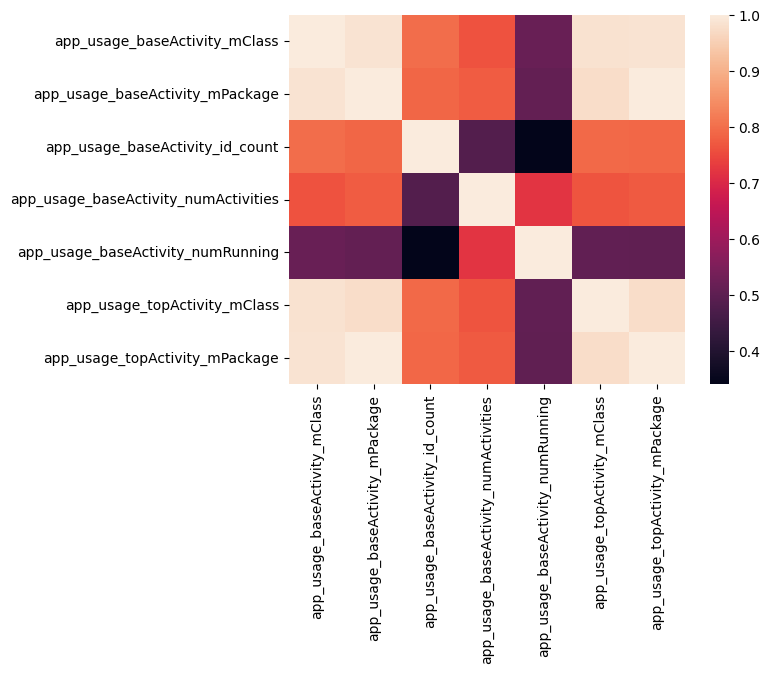

In [16]:
sns.heatmap(app_usage_df.corr())

## Activity

In [17]:
activity_path = os.path.join(datset_rel_path,'sensing','activity')

activity_files = os.listdir(activity_path)
len(activity_files)

49

In [18]:
activity_files[0].split('_')[-1].split('.')[0]

'u17'

In [19]:
AGGREGATION_DAYS = 2


activity_di = defaultdict(list)


for activity_file in tqdm(activity_files):
    usr_id = activity_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(activity_path,activity_file))

    tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'],format = "%m/%d/%Y, %H:%M:%S")

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    
    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]

        activity_di['user_id'].append(usr_id)
        activity_di['date_time'].append(time_b)

        tmp_di = dict(slice_df[' activity inference'].value_counts())

        activity_di['activity_inf_stationary_count'].append(tmp_di.get(0,0))
        activity_di['activity_inf_walking_count'].append(tmp_di.get(1,0))
        activity_di['activity_inf_running_count'].append(tmp_di.get(2,0))
        activity_di['activity_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [01:24<00:00,  1.72s/it]


In [20]:
for k,val in activity_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
activity_inf_stationary_count 2455
activity_inf_walking_count 2455
activity_inf_running_count 2455
activity_inf_unknown_count 2455


In [21]:
activity_df = pd.DataFrame(activity_di)

In [22]:
activity_df = pd.DataFrame(activity_di)

activity_df.to_csv('./data/activity_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

/tmp/ipykernel_2484173/1194580611.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(activity_df.corr())


<AxesSubplot: >

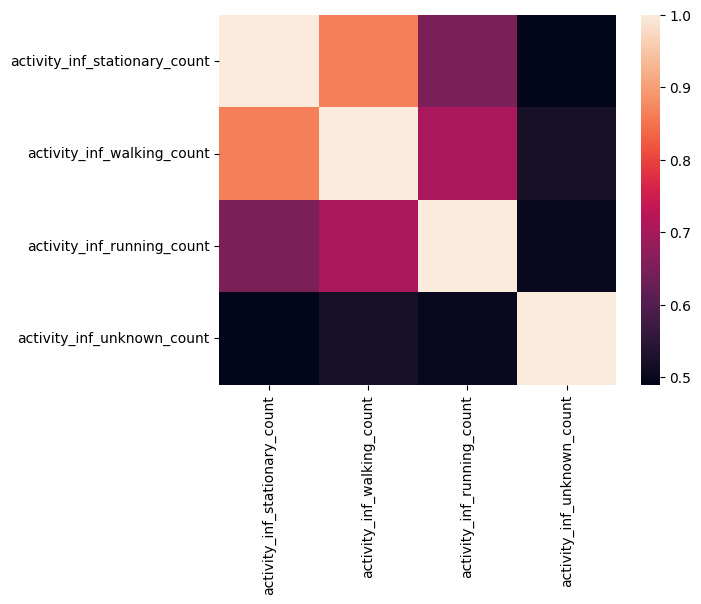

In [23]:
sns.heatmap(activity_df.corr())

In [24]:
usr_id

'u33'

In [25]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423140 entries, 0 to 423139
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp            423140 non-null  datetime64[ns]
 1    activity inference  423140 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.5 MB


## Audio

In [26]:
audio_path = os.path.join(datset_rel_path,'sensing','audio')

audio_files = os.listdir(audio_path)
len(audio_files)

49

In [27]:
audio_files[0].split('_')[-1].split('.')[0]

'u14'

In [28]:
# AGGREGATION_DAYS = 1


# audio_di = defaultdict(list)


# for audio_file in tqdm(audio_files):
#     usr_id = audio_file.split('_')[-1].split('.')[0]
    
#     # print(usr_id)
    
#     tmp_df = pd.read_csv(os.path.join(audio_path,audio_file))

#     tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda x : get_date_time(x))
#     tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])

#     # time stamps
    
#     tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

#     for time_b in tmp_li:
#         # print(time_a,time_b)
#         # if time_a == time_b:
#         #     print(time_a,time_b)
        
#         time_a = time_b - timedelta(days=AGGREGATION_DAYS)
#         slice_df = tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]

#         audio_di['user_id'].append(usr_id)
#         audio_di['date_time'].append(time_b)

#         tmp_di = dict(slice_df[' audio inference'].value_counts())

#         audio_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
#         audio_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
#         audio_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
#         audio_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


#     gc.collect()



In [29]:
# for k,val in audio_di.items():
#     print(k,len(val))

In [30]:
# audio_df = pd.DataFrame(audio_di)

In [31]:
# audio_df = pd.DataFrame(audio_di)

# audio_df.to_csv('./data/audio_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

In [32]:
# sns.heatmap(activity_df.corr())

## Conversation

In [33]:
conv_path = os.path.join(datset_rel_path,'sensing','conversation')

conv_files = os.listdir(conv_path)
len(conv_files)

49

In [34]:
conv_files[0].split('a')[-1].split('.')[0]

'tion_u08'

In [35]:
AGGREGATION_DAYS = 2


conv_di = defaultdict(list)


for conv_file in tqdm(conv_files):
    usr_id = conv_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(conv_path,conv_file))

    tmp_df['start_timestamp'] = tmp_df['start_timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['start_timestamp'] = pd.to_datetime(tmp_df['start_timestamp'])

    tmp_df[' end_timestamp'] = tmp_df[' end_timestamp'].apply(lambda x : get_date_time(x))
    tmp_df[' end_timestamp'] = pd.to_datetime(tmp_df[' end_timestamp'])

    tmp_df['conv_dur'] = tmp_df[' end_timestamp'] - tmp_df['start_timestamp']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start_timestamp) & (tmp_df[' end_timestamp']< time_b)]

        conv_di['user_id'].append(usr_id)
        conv_di['date_time'].append(time_b)
        conv_di['conversation_hours'].append(slice_df['conv_dur'].sum().seconds//3600)
        conv_di['conversation_minutes'].append(slice_df['conv_dur'].sum().seconds//60)


        # tmp_di = dict(slice_df[' audio inference'].value_counts())

        # conv_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        # conv_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        # conv_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        # conv_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [00:14<00:00,  3.40it/s]


In [36]:
for k,val in conv_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
conversation_hours 2455
conversation_minutes 2455


In [37]:
conv_df = pd.DataFrame(conv_di)

In [38]:
conv_df.head()

,user_id,date_time,conversation_hours,conversation_minutes
0,u08,2013-03-26 19:04:00,0,0
1,u08,2013-03-26 20:16:00,0,0
2,u08,2013-03-26 23:15:00,0,11
3,u08,2013-03-27 02:11:00,0,11
4,u08,2013-03-27 10:06:00,2,157


In [39]:
conv_df.to_csv('./data/conv_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

/tmp/ipykernel_2484173/930043110.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(conv_df.corr())


<AxesSubplot: >

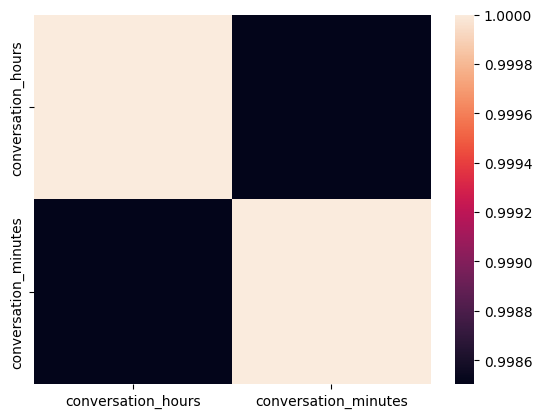

In [40]:
sns.heatmap(conv_df.corr())

## Dark

In [43]:
dark_path = os.path.join(datset_rel_path,'sensing','dark')

dark_files = os.listdir(dark_path)
len(dark_files)

49

In [57]:
dark_files[0].split('_')[-1].split('.')[0]


'u41'

In [52]:
AGGREGATION_DAYS = 2


dark_di = defaultdict(list)


for dark_file in tqdm(dark_files):
    usr_id = dark_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(dark_path,dark_file))

    tmp_df['start'] = tmp_df['start'].apply(lambda x : get_date_time(x))
    tmp_df['start'] = pd.to_datetime(tmp_df['start'])

    tmp_df['end'] = tmp_df['end'].apply(lambda x : get_date_time(x))
    tmp_df['end'] = pd.to_datetime(tmp_df['end'])

    tmp_df['dark_dur'] = tmp_df['end'] - tmp_df['start']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start) & (tmp_df['end']< time_b)]

        dark_di['user_id'].append(usr_id)
        dark_di['date_time'].append(time_b)
        dark_di['dark_hours'].append(slice_df['dark_dur'].sum().seconds//3600)
        dark_di['dark_minutes'].append(slice_df['dark_dur'].sum().seconds//60)
        dark_di['dark_seconds'].append(slice_df['dark_dur'].sum().seconds)


        # tmp_di = dict(slice_df[' audio inference'].value_counts())

        # conv_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        # conv_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        # conv_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        # conv_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [00:07<00:00,  6.20it/s]


In [53]:
for k,val in dark_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
dark_hours 2455
dark_minutes 2455
dark_seconds 2455


In [54]:
dark_df = pd.DataFrame(dark_di)

In [55]:
dark_df.head()

,user_id,date_time,dark_hours,dark_minutes,dark_seconds
0,u41,2013-03-31 16:12:00,4,286,17195
1,u41,2013-04-03 18:43:00,3,219,13140
2,u41,2013-04-03 23:00:00,4,296,17795
3,u41,2013-04-08 22:47:00,0,0,0
4,u41,2013-04-13 15:00:00,14,858,51484


In [56]:
dark_df.to_csv('./data/dark_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

## Phone charge

In [58]:
phonecharge_path = os.path.join(datset_rel_path,'sensing','phonecharge')

phonecharge_files = os.listdir(phonecharge_path)
len(phonecharge_files)

49

In [59]:
phonecharge_files[0].split('_')[-1].split('.')[0]


'u46'

In [60]:
AGGREGATION_DAYS = 2


phonecharge_di = defaultdict(list)


for phonecharge_file in tqdm(phonecharge_files):
    usr_id = phonecharge_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(phonecharge_path,phonecharge_file))

    tmp_df['start'] = tmp_df['start'].apply(lambda x : get_date_time(x))
    tmp_df['start'] = pd.to_datetime(tmp_df['start'])

    tmp_df['end'] = tmp_df['end'].apply(lambda x : get_date_time(x))
    tmp_df['end'] = pd.to_datetime(tmp_df['end'])

    tmp_df['phonecharge_dur'] = tmp_df['end'] - tmp_df['start']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start) & (tmp_df['end']< time_b)]

        phonecharge_di['user_id'].append(usr_id)
        phonecharge_di['date_time'].append(time_b)
        phonecharge_di['phonecharge_hours'].append(slice_df['phonecharge_dur'].sum().seconds//3600)
        phonecharge_di['phonecharge_minutes'].append(slice_df['phonecharge_dur'].sum().seconds//60)
        phonecharge_di['phonecharge_seconds'].append(slice_df['phonecharge_dur'].sum().seconds)


        # tmp_di = dict(slice_df[' audio inference'].value_counts())

        # conv_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        # conv_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        # conv_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        # conv_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [00:07<00:00,  6.76it/s]


In [61]:
for k,val in phonecharge_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
phonecharge_hours 2455
phonecharge_minutes 2455
phonecharge_seconds 2455


In [62]:
phonecharge_df = pd.DataFrame(phonecharge_di)

In [63]:
phonecharge_df.head()

,user_id,date_time,phonecharge_hours,phonecharge_minutes,phonecharge_seconds
0,u46,2013-03-31 17:20:00,1,60,3612
1,u46,2013-03-31 20:56:00,3,219,13172
2,u46,2013-03-31 22:05:00,3,219,13172
3,u46,2013-03-31 23:03:00,3,219,13172
4,u46,2013-04-01 02:05:00,5,305,18343


In [64]:
phonecharge_df.to_csv('./data/phonecharge_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

## Phone lock

In [65]:
phonelock_path = os.path.join(datset_rel_path,'sensing','phonelock')

phonelock_files = os.listdir(phonelock_path)
len(phonelock_files)

49

In [66]:
phonelock_files[0].split('_')[-1].split('.')[0]


'u42'

In [67]:
AGGREGATION_DAYS = 2


phonelock_di = defaultdict(list)


for phonelock_file in tqdm(phonelock_files):
    usr_id = phonelock_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(phonelock_path,phonelock_file))

    tmp_df['start'] = tmp_df['start'].apply(lambda x : get_date_time(x))
    tmp_df['start'] = pd.to_datetime(tmp_df['start'])

    tmp_df['end'] = tmp_df['end'].apply(lambda x : get_date_time(x))
    tmp_df['end'] = pd.to_datetime(tmp_df['end'])

    tmp_df['phonelock_dur'] = tmp_df['end'] - tmp_df['start']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start) & (tmp_df['end']< time_b)]

        phonelock_di['user_id'].append(usr_id)
        phonelock_di['date_time'].append(time_b)
        phonelock_di['phonelock_hours'].append(slice_df['phonelock_dur'].sum().seconds//3600)
        phonelock_di['phonelock_minutes'].append(slice_df['phonelock_dur'].sum().seconds//60)
        phonelock_di['phonelock_seconds'].append(slice_df['phonelock_dur'].sum().seconds)


    gc.collect()



100%|██████████| 49/49 [00:07<00:00,  6.38it/s]


In [68]:
for k,val in phonelock_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
phonelock_hours 2455
phonelock_minutes 2455
phonelock_seconds 2455


In [69]:
phonelock_df = pd.DataFrame(phonelock_di)

In [70]:
phonelock_df.head()

,user_id,date_time,phonelock_hours,phonelock_minutes,phonelock_seconds
0,u42,2013-04-02 05:10:00,9,540,32439
1,u42,2013-04-02 19:27:00,21,1279,76794
2,u42,2013-04-02 19:36:00,21,1279,76794
3,u42,2013-04-02 23:57:00,3,180,10813
4,u42,2013-04-03 17:14:00,14,882,52930


In [71]:
phonelock_df.to_csv('./data/phonelock_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

In [72]:
audio_df = pd.read_csv('./data/sensing_agg_data_0.5_lag/audio_lag_0.5_df.csv')
audio_df.head()

,user_id,date_time,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count
0,u00,2013-03-25 11:54:00,0,0,0,0
1,u00,2013-03-25 20:33:00,0,0,0,0
2,u00,2013-03-26 18:12:00,0,0,0,0
3,u00,2013-03-27 19:25:00,9617,8924,3137,0
4,u00,2013-03-28 11:43:00,9173,1899,1377,0


In [73]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   user_id                  2455 non-null   object
 1   date_time                2455 non-null   object
 2   audio_inf_silence_count  2455 non-null   int64 
 3   audio_inf_voice_count    2455 non-null   int64 
 4   audio_inf_noise_count    2455 non-null   int64 
 5   audio_inf_unknown_count  2455 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 115.2+ KB


In [74]:
audio_df['date_time'] = pd.to_datetime(audio_df['date_time'])

## Merging sensing data

In [75]:
len(label_df),len(activity_df),len(app_usage_df)

(2455, 2455, 2455)

In [76]:
merged_sensing_df = activity_df.merge(app_usage_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,app_usage_topActivity_mPackage
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,408,9,7
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,692,13,10
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,736,11,10
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,1057,8,6
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,1067,17,14


In [77]:
len(merged_sensing_df)

2455

In [78]:
merged_sensing_df = merged_sensing_df.merge(audio_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,app_usage_topActivity_mPackage,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,408,9,7,11053,468,359,0
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,692,13,10,10789,131,288,0
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,736,11,10,10868,4669,1399,0
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,1057,8,6,8673,510,2367,0
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,1067,17,14,9609,2132,1704,0


In [79]:
len(merged_sensing_df),len(merged_sensing_df.columns)

(2455, 17)

In [81]:
merged_sensing_df['user_id'].nunique()

48

In [82]:
merged_sensing_df = merged_sensing_df.merge(conv_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,app_usage_topActivity_mPackage,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count,conversation_hours,conversation_minutes
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,408,9,7,11053,468,359,0,8,500
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,692,13,10,10789,131,288,0,8,484
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,736,11,10,10868,4669,1399,0,9,563
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,1057,8,6,8673,510,2367,0,3,193
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,1067,17,14,9609,2132,1704,0,8,533


In [83]:
len(merged_sensing_df),len(merged_sensing_df.columns)

(2455, 19)

In [84]:
merged_sensing_df = merged_sensing_df.merge(dark_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,app_usage_topActivity_mPackage,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count,conversation_hours,conversation_minutes,dark_hours,dark_minutes,dark_seconds
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,...,7,11053,468,359,0,8,500,0,55,3342
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,...,10,10789,131,288,0,8,484,1,62,3729
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,...,10,10868,4669,1399,0,9,563,12,726,43616
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,...,6,8673,510,2367,0,3,193,1,75,4527
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,...,14,9609,2132,1704,0,8,533,4,272,16329


In [85]:
len(merged_sensing_df)

2455

In [86]:
merged_sensing_df = merged_sensing_df.merge(phonecharge_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,audio_inf_noise_count,audio_inf_unknown_count,conversation_hours,conversation_minutes,dark_hours,dark_minutes,dark_seconds,phonecharge_hours,phonecharge_minutes,phonecharge_seconds
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,...,359,0,8,500,0,55,3342,1,67,4044
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,...,288,0,8,484,1,62,3729,2,170,10253
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,...,1399,0,9,563,12,726,43616,1,108,6485
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,...,2367,0,3,193,1,75,4527,5,336,20179
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,...,1704,0,8,533,4,272,16329,15,957,57454


In [87]:
merged_sensing_df = merged_sensing_df.merge(phonelock_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,conversation_minutes,dark_hours,dark_minutes,dark_seconds,phonecharge_hours,phonecharge_minutes,phonecharge_seconds,phonelock_hours,phonelock_minutes,phonelock_seconds
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,...,500,0,55,3342,1,67,4044,1,105,6327
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,...,484,1,62,3729,2,170,10253,2,127,7660
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,...,563,12,726,43616,1,108,6485,1,78,4699
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,...,193,1,75,4527,5,336,20179,1,63,3796
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,...,533,4,272,16329,15,957,57454,3,226,13574


In [88]:
merged_sensing_df = merged_sensing_df.merge(label_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,...,2013,3,28,15,8,Thu,12,stress_ema,1,0
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,...,2013,3,30,16,6,Sat,12,stress_ema,2,1
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,...,2013,4,11,16,53,Thu,14,stress_ema,3,1
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,...,2013,4,14,15,33,Sun,14,stress_ema,3,1
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,...,2013,4,15,14,7,Mon,15,stress_ema,3,1


In [89]:
len(merged_sensing_df),len(merged_sensing_df.columns)

(2455, 38)

In [90]:
merged_sensing_df.to_csv('./data/sensing_data_2.csv',index=False)

In [ ]:
tmp_df.columns

In [ ]:
tmp_df.head()

In [ ]:
time_a,time_b

In [ ]:
tmp_df[time_a < tmp_df.start_timestamp]

In [ ]:
tmp_df[time_a < tmp_df.start_timestamp]

In [ ]:
slice_df['conv_dur'].sum(),slice_df['conv_dur'].sum().seconds//60 ,slice_df['conv_dur'].sum().seconds//3600 

In [ ]:
slice_df.columns

In [ ]:
dict(slice_df[' activity inference'].value_counts()).get(0)

In [ ]:
pd.DataFrame(activity_di)

In [ ]:
tmp_df.info()

In [ ]:
tmp_df.info()

In [ ]:
tmp_li[0]

In [ ]:
tmp_li[0] - timedelta(days=1)

In [ ]:
for t in tmp_li:

    a = t - timedelta(days=1)

    tmp_df

In [ ]:

for time_b in tmp_li:
    # print(time_a,time_b)
    # if time_a == time_b:
    #     print(time_a,time_b)
    time_a = t - timedelta(days=1)
    tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]


# tmp_df['timestamp']

In [ ]:
tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]#['RUNNING_TASKS_numActivities'].sum()

In [ ]:
# # label_df['date_time'].nunique(),len(label_df)

# dup_sum =0

# for u in label_df['user_id'].unique():
#     t_df = label_df[label_df['user_id'] == u ]
#     uni_en = len(set(t_df['date_time']))
#     en = len(t_df)
#     if uni_en != en:
#         print(u,uni_en,en)
#         dup_sum += en-uni_en

# dup_sum

